## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("Paired")
plt.rcParams["figure.facecolor"] = "white"

In [3]:
specter2_df = pd.read_csv('specter2_chunking_strategies_comparison2.csv',index_col=0)
specter_df = pd.read_csv('specter_chunking_strategies_comparison2.csv',index_col=0)
scincl_df = pd.read_csv('scincl_chunking_strategies_comparison2.csv',index_col=0)
scibert_df = pd.read_csv('scibert_chunking_strategies_comparison2.csv',index_col=0)
pubmedbert_df = pd.read_csv('pubmedbert_chunking_strategies_comparison2.csv',index_col=0)
mpnet_df = pd.read_csv('mpnet_chunking_strategies_comparison_new_2.csv',index_col=0)
minilm_df = pd.read_csv('minilm_chunking_strategies_comparison_new_2.csv',index_col=0)

cols_to_drop = ['recall_std', 'precision_std', 'iou_std', 'mrr_std']

dataframes = [specter2_df, specter_df, scincl_df, scibert_df, pubmedbert_df, mpnet_df, minilm_df]

dataframes_processed = [df.drop(columns=cols_to_drop, errors='ignore') for df in dataframes]

specter2_df, specter_df, scincl_df, scibert_df, pubmedbert_df, mpnet_df, minilm_df = dataframes_processed

runtime_metrics_df = pd.read_csv('runtime_metrics_new_2_concat.csv')

In [4]:
specter2_df.head()

,strategy,recall_mean,precision_mean,iou_mean,hit_rate,mrr_mean
0,recursive_cs256_co0,0.415171,0.087457,0.078703,0.327801,0.326141
1,recursive_cs500_co0,0.455915,0.047725,0.045406,0.378976,0.386676
2,recursive_cs256_co25,0.425295,0.088285,0.079757,0.334716,0.328077
3,recursive_cs500_co50,0.446436,0.047177,0.044905,0.359613,0.368396
4,semantic,0.286088,0.046260,0.035373,0.182573,0.194329


In [5]:
runtime_metrics_df.head()

,embedding_model,strategy,chunking_time_s,num_chunks,embedding_faiss_time_s,search_time_s,metrics_time_s,total_embedding_model_time_s
0,specter2,recursive_cs256_co0,0.33,70580,173.71,13.08,0.05,1897.44
1,specter2,recursive_cs500_co0,0.30,32326,160.35,5.82,0.10,1897.44
2,specter2,recursive_cs256_co25,0.31,71094,172.71,12.94,0.05,1897.44
3,specter2,recursive_cs500_co50,0.30,32787,159.45,5.89,0.09,1897.44
4,specter2,semantic,1033.89,17054,150.48,3.08,0.11,1897.44


In [6]:
code_to_strategy_num_mapping = {'recursive_cs256_co0': 'S1', 
                                'recursive_cs500_co0': 'S2', 
                                'recursive_cs256_co25': 'S3', 
                                'recursive_cs500_co50': 'S4', 
                                'semantic': 'S5'}
strategy_num_to_description_mapping = {'S1': 'Strategy Type: Recursive Splitting\nChunk Size: 256\nChunk Overlap: 0', 
                                       'S2': 'Strategy Type: Recursive Splitting\nChunk Size: 512\nChunk Overlap: 0', 
                                       'S3': 'Strategy Type: Recursive Splitting\nChunk Size: 256\nChunk Overlap: 25', 
                                       'S4': 'Strategy Type: Recursive Splitting\nChunk Size: 512\nChunk Overlap: 50', 
                                       'S5': 'Strategy Type: Semantic Chunking\nBreakpoint Type: Percentile\nThreshold: 90'}

In [7]:
specter2_df['strategy']

0     recursive_cs256_co0
1     recursive_cs500_co0
2    recursive_cs256_co25
3    recursive_cs500_co50
4                semantic
Name: strategy, dtype: object

In [8]:
[code_to_strategy_num_mapping[strategy] for strategy in specter2_df['strategy']]

['S1', 'S2', 'S3', 'S4', 'S5']

In [9]:
runtime_metrics_df[runtime_metrics_df['embedding_model']=='specter2'][['strategy','search_time_s']]

,strategy,search_time_s
0,recursive_cs256_co0,13.08
1,recursive_cs500_co0,5.82
2,recursive_cs256_co25,12.94
3,recursive_cs500_co50,5.89
4,semantic,3.08


## Quality Metrics Comparison

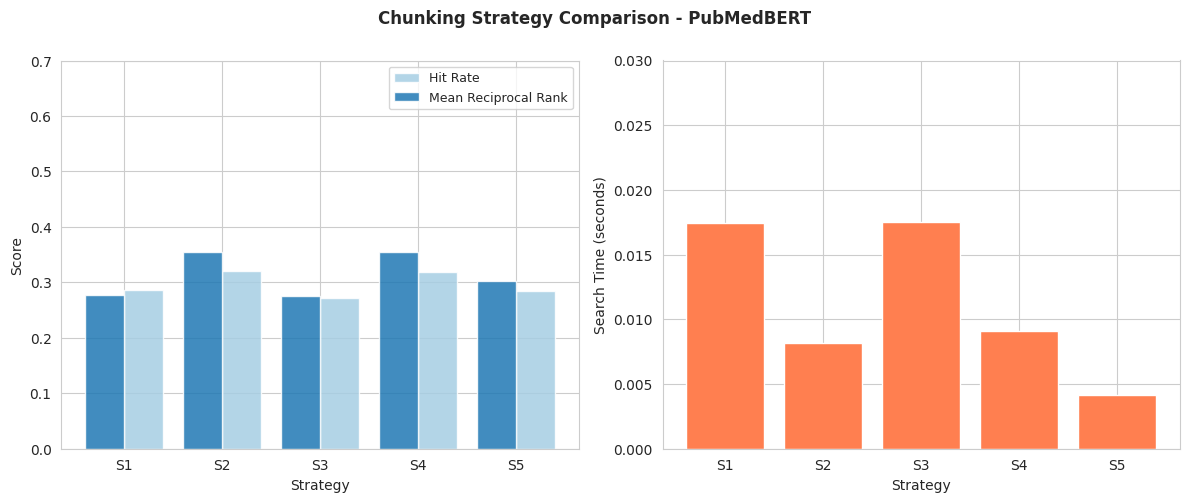

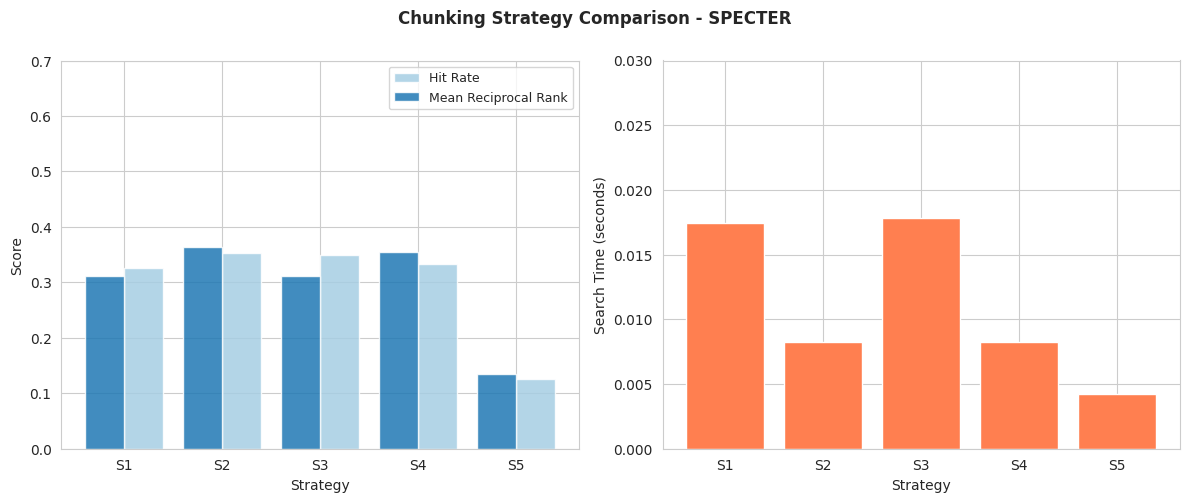

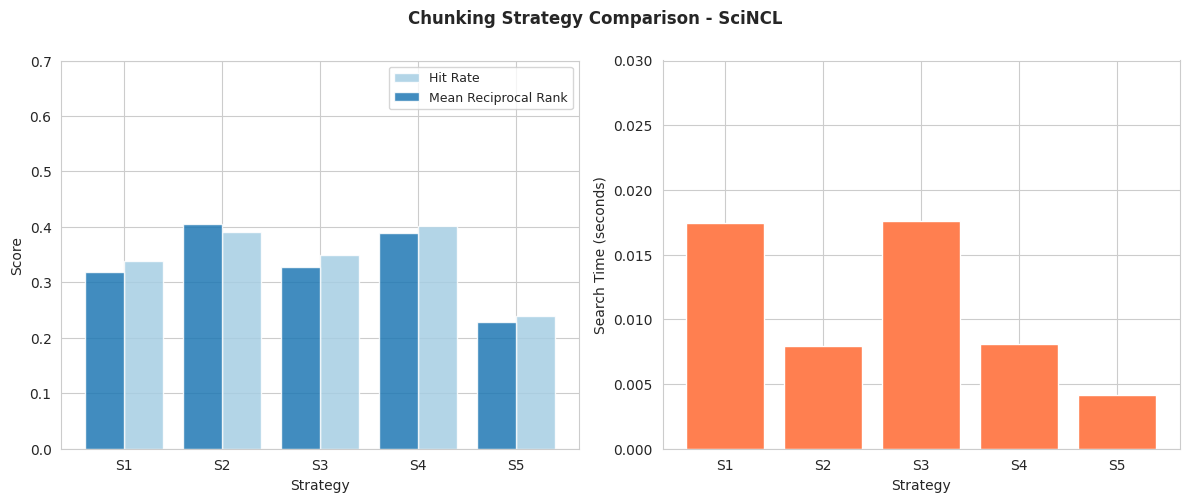

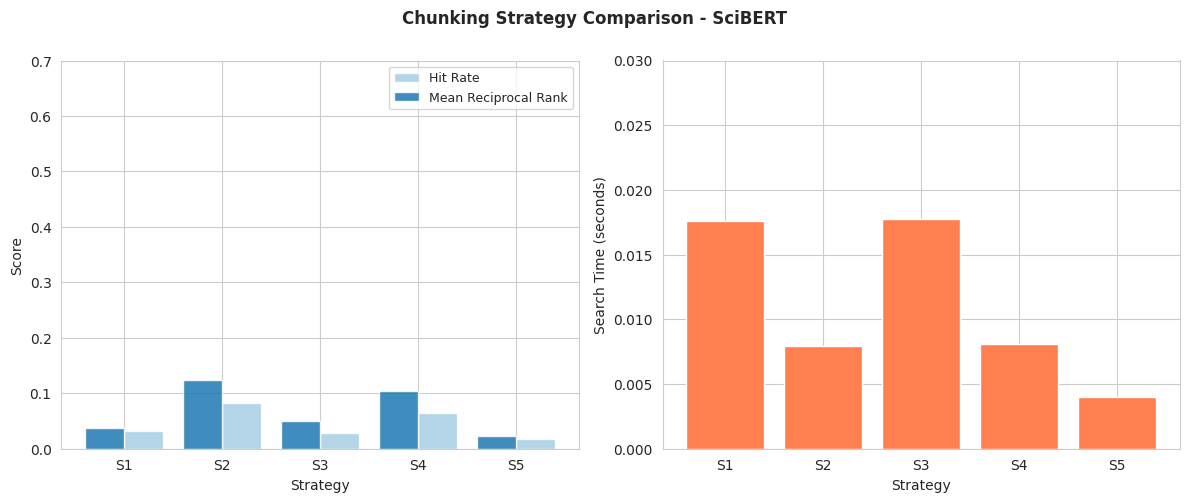

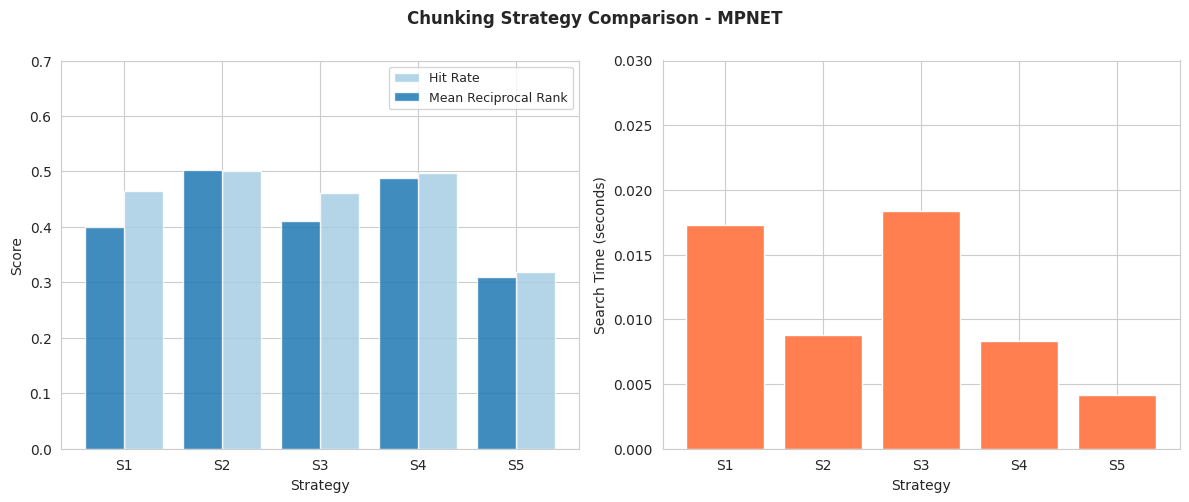

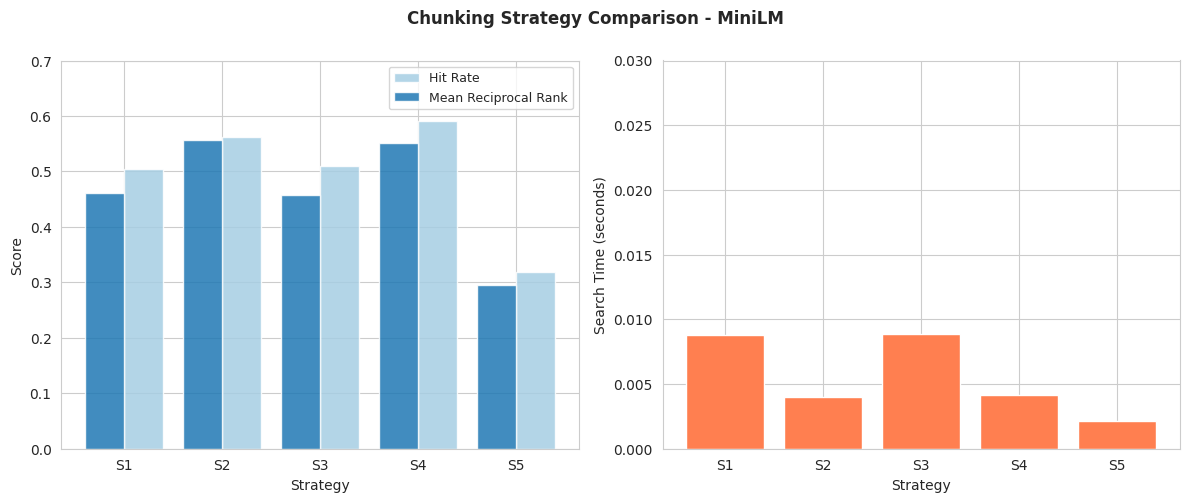

In [12]:
models = [
    # ('specter2', specter2_df, 'SPECTER2'),
    ('pubmedbert',pubmedbert_df, 'PubMedBERT'),
    ('specter', specter_df, 'SPECTER'),
    ('scincl', scincl_df, 'SciNCL'),
    ('scibert', scibert_df, 'SciBERT'),
    ('mpnet', mpnet_df, 'MPNET'),
    ('minilm', minilm_df, 'MiniLM'),
]
total_queries = 722
for model_key, model_df, model_name in models:
    figure, axes = plt.subplots(1, 2, figsize=(12, 5))
    figure.suptitle(f"Chunking Strategy Comparison - {model_name}", y=0.995, fontsize=12, fontweight="bold")
    
    ax = axes[0]
    x = np.arange(len(model_df))
    width = 0.2
    ax.bar(x + width, model_df["hit_rate"], label="Hit Rate", width=0.4, alpha=0.85)
    ax.bar(x - width, model_df["mrr_mean"], label="Mean Reciprocal Rank", width=0.4, alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels([code_to_strategy_num_mapping[strategy] for strategy in model_df['strategy']])
    ax.set_ylabel("Score")
    ax.set_xlabel("Strategy")
    ax.set_ylim(0, 0.7)
    ax.legend(fontsize=9)
    
    ax = axes[1]
    search_time = runtime_metrics_df[runtime_metrics_df['embedding_model'] == model_key][['strategy', 'search_time_s']]
    x = np.arange(len(search_time))
    ax.bar(x, search_time['search_time_s'] / total_queries, color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels([code_to_strategy_num_mapping[strategy] for strategy in search_time['strategy']])
    ax.set_ylim(0, 0.03)
    ax.set_ylabel("Search Time (seconds)")
    ax.set_xlabel("Strategy")
    
    plt.tight_layout()
    # plt.savefig(f'{model_key}_comparison.png', dpi=300, bbox_inches='tight')

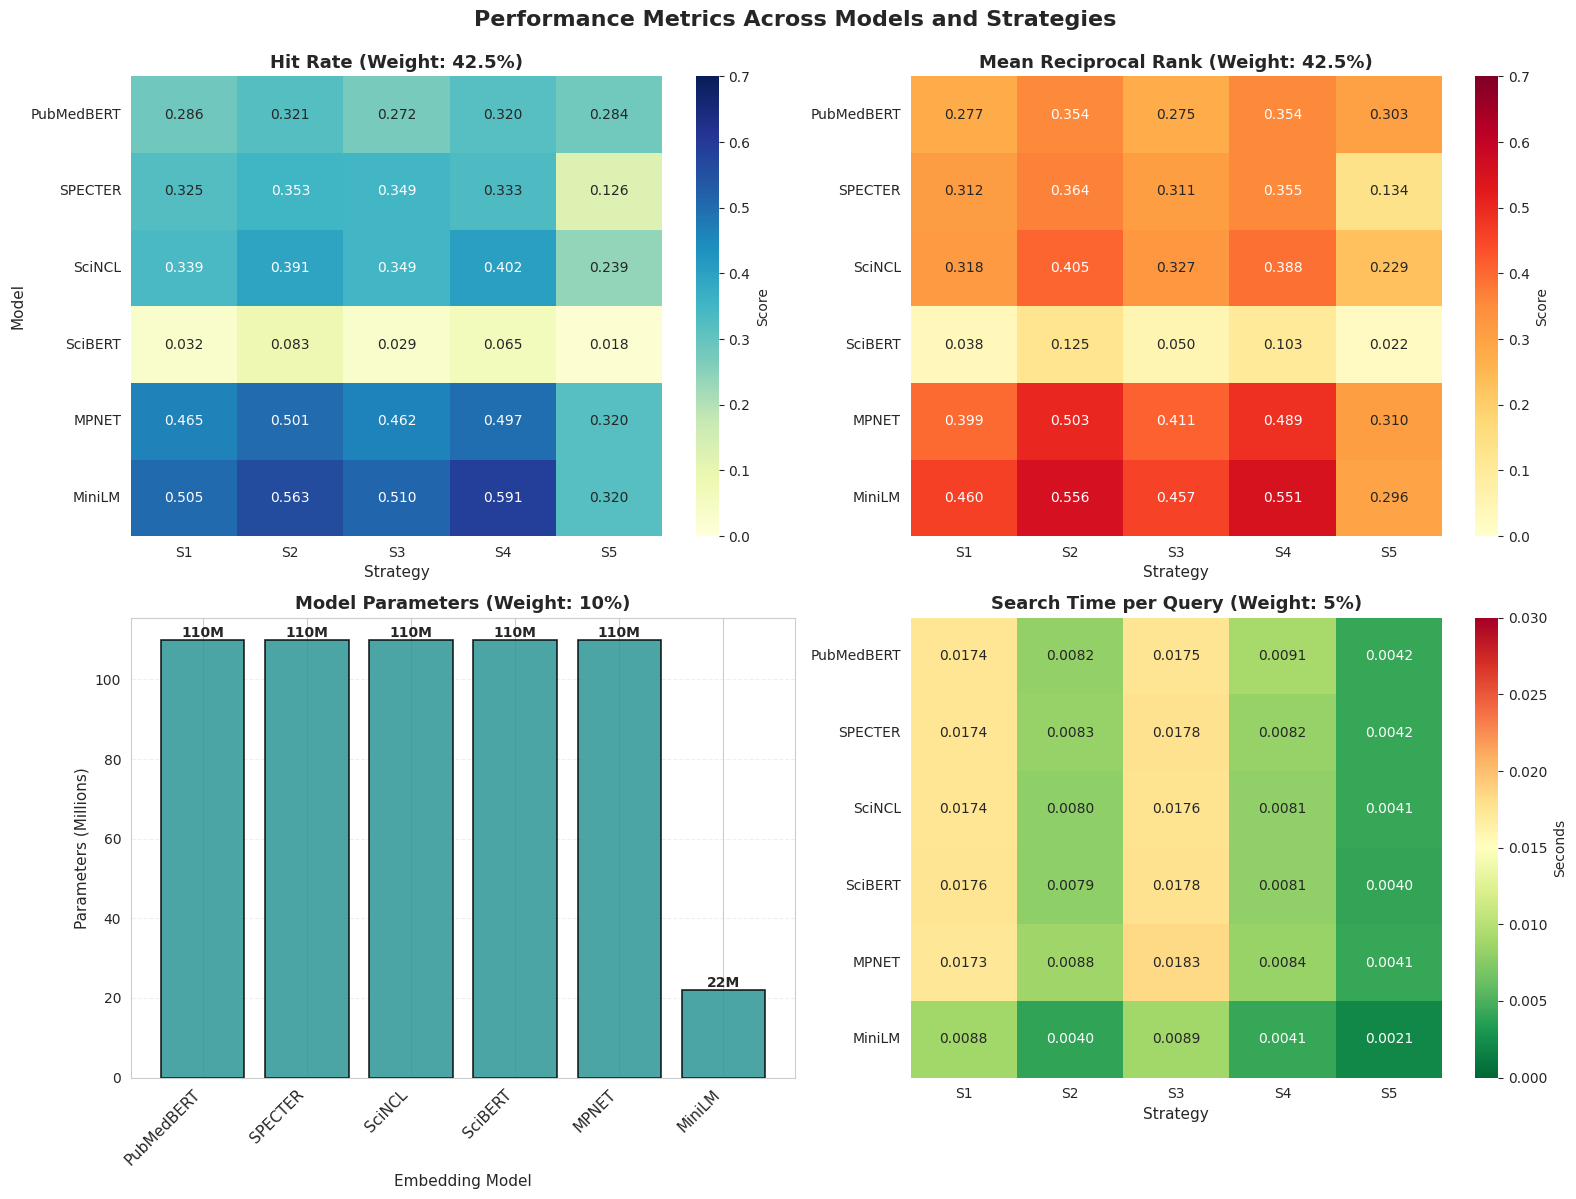

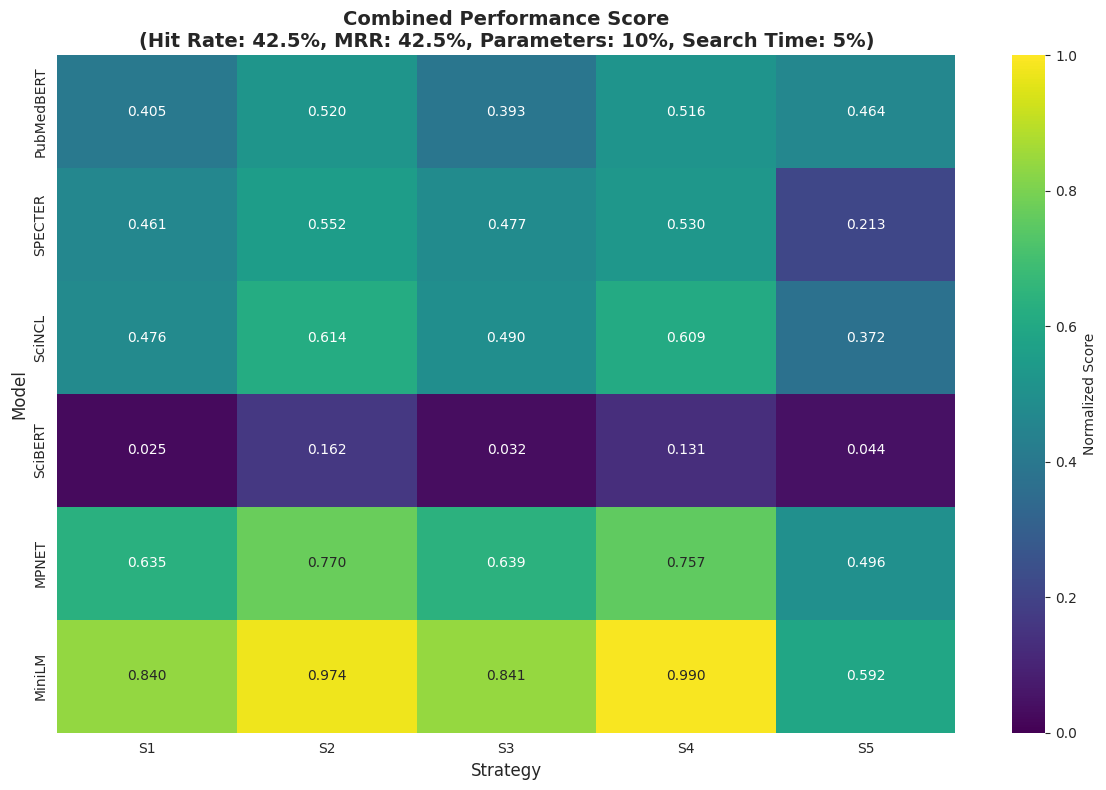

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

model_parameters = {
    # 'specter2': 110,
    'pubmedbert': 110,
    'specter': 110,
    'scincl': 110,
    'scibert': 110,
    'mpnet': 110,
    'minilm': 22
}

models = [
    ('pubmedbert',pubmedbert_df, 'PubMedBERT'),
    # ('specter2', specter2_df, 'SPECTER2'),
    ('specter', specter_df, 'SPECTER'),
    ('scincl', scincl_df, 'SciNCL'),
    ('scibert', scibert_df, 'SciBERT'),
    ('mpnet', mpnet_df, 'MPNET'),
    ('minilm', minilm_df, 'MiniLM')
]
total_queries = 722

strategies = [code_to_strategy_num_mapping[s] for s in models[0][1]['strategy']]
num_strategies = len(strategies)

hit_rate_matrix = []
mrr_matrix = []
search_time_matrix = []
params_matrix = []
model_names = []

for model_key, model_df, model_name in models:
    model_names.append(model_name)
    hit_rate_matrix.append(model_df["hit_rate"].values)
    mrr_matrix.append(model_df["mrr_mean"].values)
    search_time = runtime_metrics_df[runtime_metrics_df['embedding_model'] == model_key][['strategy', 'search_time_s']]
    search_time_per_query = search_time['search_time_s'].values / total_queries
    search_time_matrix.append(search_time_per_query)
    
    params_value = model_parameters[model_key]
    params_matrix.append([params_value] * num_strategies)

hit_rate_matrix = np.array(hit_rate_matrix)
mrr_matrix = np.array(mrr_matrix)
search_time_matrix = np.array(search_time_matrix)
params_matrix = np.array(params_matrix)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Performance Metrics Across Models and Strategies", fontsize=16, fontweight="bold", y=0.995)

sns.heatmap(hit_rate_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
            xticklabels=strategies, yticklabels=model_names, 
            ax=axes[0, 0], cbar_kws={'label': 'Score'}, vmin=0, vmax=0.7)
axes[0, 0].set_title('Hit Rate (Weight: 42.5%)', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Strategy', fontsize=11)
axes[0, 0].set_ylabel('Model', fontsize=11)

sns.heatmap(mrr_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=strategies, yticklabels=model_names, 
            ax=axes[0, 1], cbar_kws={'label': 'Score'}, vmin=0, vmax=0.7)
axes[0, 1].set_title('Mean Reciprocal Rank (Weight: 42.5%)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Strategy', fontsize=11)
axes[0, 1].set_ylabel('')

param_counts = [model_parameters[model_key] for model_key, _, _ in models]
x_params = np.arange(len(model_names))
bars_params = axes[1, 0].bar(x_params, param_counts, color="#2D9596", alpha=0.85, edgecolor='black', linewidth=1.2)
axes[1, 0].set_xticks(x_params)
axes[1, 0].set_xticklabels(model_names, rotation=45, ha='right', fontsize=11)
axes[1, 0].set_ylabel("Parameters (Millions)", fontsize=11)
axes[1, 0].set_xlabel("Embedding Model", fontsize=11)
axes[1, 0].set_title('Model Parameters (Weight: 10%)', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')

for bar in bars_params:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}M',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

sns.heatmap(search_time_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            xticklabels=strategies, yticklabels=model_names, 
            ax=axes[1, 1], cbar_kws={'label': 'Seconds'}, vmin=0, vmax=0.03)
axes[1, 1].set_title('Search Time per Query (Weight: 5%)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Strategy', fontsize=11)
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

hit_rate_norm = (hit_rate_matrix - hit_rate_matrix.min()) / (hit_rate_matrix.max() - hit_rate_matrix.min())
mrr_norm = (mrr_matrix - mrr_matrix.min()) / (mrr_matrix.max() - mrr_matrix.min())
search_time_norm = 1 - (search_time_matrix - search_time_matrix.min()) / (search_time_matrix.max() - search_time_matrix.min())
params_norm = 1 - (params_matrix - params_matrix.min()) / (params_matrix.max() - params_matrix.min())

combined_score = (hit_rate_norm * 0.425 + mrr_norm * 0.425 + params_norm * 0.10 + search_time_norm * 0.05)

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(combined_score, annot=True, fmt='.3f', cmap='viridis', 
            xticklabels=strategies, yticklabels=model_names, 
            ax=ax, cbar_kws={'label': 'Normalized Score'}, vmin=0, vmax=1)
ax.set_title('Combined Performance Score\n(Hit Rate: 42.5%, MRR: 42.5%, Parameters: 10%, Search Time: 5%)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Strategy', fontsize=12)
ax.set_ylabel('Model', fontsize=12)

plt.tight_layout()
plt.show()

## Final Verdict

`MiniLM` embedding model with with `recursive text splitting` with a `chunk Size of 512` and `chunk overlap of 50` provides the best tradeoff between quality and latency.